# Exercises: Data Preparation Case Studies

The goal of the exercises below is for you to practice applying preprocessing steps correctly in a model evaluation workflow, using `Pipeline` and `Cross-Validation` to avoid data leakage.

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
from numpy import mean, std, absolute
import matplotlib.pyplot as plt 

# Sklearn Preprocessing
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, RobustScaler,
    PowerTransformer, QuantileTransformer, KBinsDiscretizer,
    PolynomialFeatures, OneHotEncoder, LabelEncoder
)

from sklearn.experimental import enable_iterative_imputer # Needed for IterativeImputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer

# Sklearn Feature Selection
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_regression, RFE

# Sklearn Modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, HuberRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

# Sklearn Model Selection and Metrics
from sklearn.model_selection import (
    cross_val_score, RepeatedStratifiedKFold, RepeatedKFold,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error

# Sklearn Datasets
from sklearn.datasets import make_classification, make_regression, fetch_openml, fetch_california_housing

## --- Helper Functions ---

In [6]:
def load_horse_colic():
    """Load the Horse Colic dataset from URL and handle missing values."""
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/horse-colic.csv'
    df = pd.read_csv(url, header=None, na_values='?')
    # Column 23 is the outcome (surgical or not), no missing values
    # Other columns are inputs
    data = df.values
    ix = [i for i in range(data.shape[1]) if i != 23]
    X, y = data[:, ix], data[:, 23]
    # Ensure y is integer
    y = y.astype(int)
    return X, y

def load_sonar():
    """Load the Sonar dataset from URL."""
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/sonar.csv'
    df = pd.read_csv(url, header=None)
    data = df.values
    X, y = data[:, :-1], data[:, -1]
    X = X.astype('float32')
    y = LabelEncoder().fit_transform(y.astype('str'))
    return X, y

def load_abalone():
    """Load the Abalone dataset from URL."""
    url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/abalone.csv'
    df = pd.read_csv(url, header=None)
    # Last column is the target (rings)
    last_ix = len(df.columns) - 1
    X, y = df.drop(last_ix, axis=1), df[last_ix]
    return X, y

### Dataset Introduction: Pima Indians Diabetes

This is a classic classification dataset, loaded directly from a URL. The goal is to predict whether a person has diabetes ('class' column) based on 8 medical features. 

An important characteristic of this dataset is that it contains invalid zero values (e.g., blood pressure = 0 in columns like 'pres', 'plas'...), which require Data Cleaning before processing.

## --- Problem 1: Compare the effectiveness of Scaling with KNN ---

In [7]:
print("\n--- Problem 1: Pima Diabetes Data (Scaling) ---")
# 1. Load the Pima Indians Diabetes dataset from URL
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
names = ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class']
df_pima = pd.read_csv(url, header=None, names=names)

# 2. Replace invalid zero values with NaN in specific columns
cols_with_zero_nan = ['plas', 'pres', 'skin', 'insu', 'mass']
df_pima[cols_with_zero_nan] = df_pima[cols_with_zero_nan].replace(0, np.nan)

# Split X and y (y is already 0 or 1, no LabelEncoder needed)
X_pima = df_pima.drop('class', axis=1).values
y_pima = df_pima['class'].values
print("Pima Indians Diabetes dataset loaded successfully from URL.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Create 3 separate Pipelines (MinMaxScaler, StandardScaler, RobustScaler).
# 2. Each Pipeline must include 3 steps: ('i', SimpleImputer(strategy='mean')), ('s', [Corresponding Scaler]), ('m', KNeighborsClassifier()).
# 3. Define RepeatedStratifiedKFold (10 splits, 3 repeats, random_state=1).
# 4. Evaluate and print the mean accuracy for all 3 pipelines.
# 5. (Optional) Plot a boxplot to compare the results.


--- Problem 1: Pima Diabetes Data (Scaling) ---
Pima Indians Diabetes dataset loaded successfully from URL.


In [26]:
df_pima.head()

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [27]:
df_pima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   preg    768 non-null    int64  
 1   plas    763 non-null    float64
 2   pres    733 non-null    float64
 3   skin    541 non-null    float64
 4   insu    394 non-null    float64
 5   mass    757 non-null    float64
 6   pedi    768 non-null    float64
 7   age     768 non-null    int64  
 8   class   768 non-null    int64  
dtypes: float64(6), int64(3)
memory usage: 54.1 KB


>MinMaxScaler Accuracy: 0.746 (0.045)
>StandardScaler Accuracy: 0.741 (0.051)
>RobustScaler Accuracy: 0.736 (0.051)


C:\Users\Admin\AppData\Local\Temp\ipykernel_24716\2519635932.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results_scaling.values(), labels=results_scaling.keys(), showmeans=True)


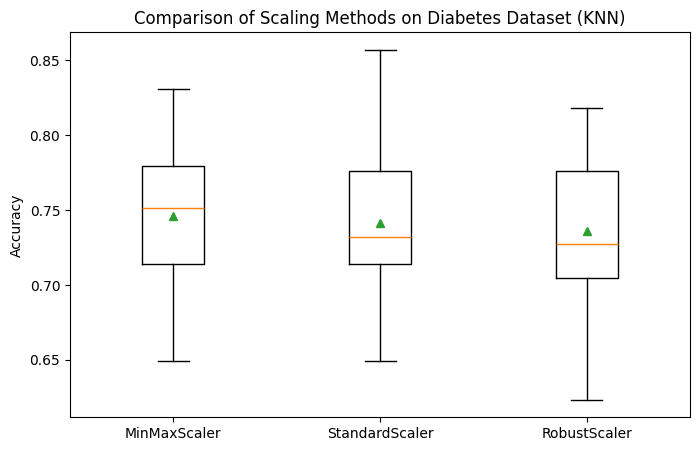

In [35]:
# 3. Sử dụng SimpleImputer để điền giá trị thiếu trước khi scale
imputer_pima = SimpleImputer(strategy='mean')

# 4. Định nghĩa các pipeline với các phương pháp scaling khác nhau
pipelines = {
    'MinMaxScaler': Pipeline(steps=[('i', imputer_pima), ('s', MinMaxScaler()), ('m', KNeighborsClassifier())]),
    'StandardScaler': Pipeline(steps=[('i', imputer_pima), ('s', StandardScaler()), ('m', KNeighborsClassifier())]),
    'RobustScaler': Pipeline(steps=[('i', imputer_pima), ('s', RobustScaler()), ('m', KNeighborsClassifier())])
}

# 5. Định nghĩa quy trình đánh giá chéo
cv_class = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# 6. Đánh giá từng pipeline
results_scaling = {}
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X_pima, y_pima, scoring='accuracy', cv=cv_class, n_jobs=-1)
    results_scaling[name] = scores
    # 7. In kết quả
    print(f'>{name} Accuracy: {mean(scores):.3f} ({std(scores):.3f})')

# 8. Vẽ biểu đồ so sánh
plt.figure(figsize=(8, 5))
plt.boxplot(results_scaling.values(), labels=results_scaling.keys(), showmeans=True)
plt.title('Comparison of Scaling Methods on Diabetes Dataset (KNN)')
plt.ylabel('Accuracy')
plt.show()

### Knowledge Check (Problem 1)

**Question 1:** Why do we need `SimpleImputer` before `scaling` in this pipeline?

**Question 2:** How is the `KNeighborsClassifier` (KNN) model affected by data scaling?


## --- Problem 2: Apply Feature Selection (SelectKBest) ---

In [8]:
print("\n--- Problem 2: Pima Diabetes Data (SelectKBest) ---")
# 1. Load and 2. Process Pima data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
names = ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class']
df_pima = pd.read_csv(url, header=None, names=names)
cols_with_zero_nan = ['plas', 'pres', 'skin', 'insu', 'mass']
df_pima[cols_with_zero_nan] = df_pima[cols_with_zero_nan].replace(0, np.nan)
X_pima = df_pima.drop('class', axis=1).values
y_pima = df_pima['class'].values # y is already 0/1
print("Pima dataset loaded and processed.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Create a single Pipeline that includes the following steps:
#    a. ('i', SimpleImputer(strategy='mean'))
#    b. ('s', SelectKBest(score_func=f_classif, k=4)) 
#    c. ('m', LogisticRegression(solver='liblinear'))
# 2. Define RepeatedStratifiedKFold.
# 3. Evaluate the pipeline using cross_val_score and print the mean accuracy.


--- Problem 2: Pima Diabetes Data (SelectKBest) ---
Pima dataset loaded and processed.


In [36]:
# --- EXERCISE REQUIREMENTS --- 
# 1. Create a single Pipeline that includes the following steps:
#    a. ('i', SimpleImputer(strategy='mean'))
#    b. ('s', SelectKBest(score_func=f_classif, k=4)) 
#    c. ('m', LogisticRegression(solver='liblinear'))
# 2. Define RepeatedStratifiedKFold.
# 3. Evaluate the pipeline using cross_val_score and print the mean accuracy.

In [39]:
pipeline_2 = Pipeline(steps =
[('i', SimpleImputer(strategy='mean')),
('s', SelectKBest(score_func=f_classif, k=4)),
('m', LogisticRegression(solver='liblinear'))           
                      ])
cv_class_2 = RepeatedStratifiedKFold()

evaluation = cross_val_score(pipeline_2, X_pima, y_pima, scoring='accuracy', cv=cv_class_2, n_jobs=-1)
print(f'The mean accuracy is:{evaluation.mean()}')


The mean accuracy is:0.7578422884305237


### Knowledge Check (Problem 2)

**Question 1:** What does `f_classif` (ANOVA F-test) used in `SelectKBest` measure?

**Question 2:** Why do we place `SimpleImputer` *before* `SelectKBest` in the pipeline?


## --- Problem 3: Tune the number of features 'k' using GridSearchCV ---

In [9]:
print("\n--- Problem 3: Pima Diabetes Data (GridSearchCV) ---")
# 1. Load and process Pima data
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.csv'
names = ['preg', 'plas', 'pres', 'skin', 'insu', 'mass', 'pedi', 'age', 'class']
df_pima = pd.read_csv(url, header=None, names=names)
cols_with_zero_nan = ['plas', 'pres', 'skin', 'insu', 'mass']
df_pima[cols_with_zero_nan] = df_pima[cols_with_zero_nan].replace(0, np.nan)
X_pima = df_pima.drop('class', axis=1).values
y_pima = df_pima['class'].values # y is already 0/1
print("Pima dataset loaded and processed.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Create a Pipeline similar to Problem 2, but do *not* specify 'k' in SelectKBest.
#    (Just use: SelectKBest(score_func=f_classif)).
# 2. Define a 'param_grid' to search for 'k'. Hint: {'s__k': list(range(1, X_pima.shape[1] + 1))}
#    (Assuming your SelectKBest step is named 's').
# 3. Define RepeatedStratifiedKFold.
# 4. Create a GridSearchCV object wrapping the Pipeline, param_grid, and cv.
# 5. Run grid_search.fit() and print the best_params_ and best_score_.


--- Problem 3: Pima Diabetes Data (GridSearchCV) ---
Pima dataset loaded and processed.


In [41]:
pipeline_3 = Pipeline(steps =
[('i', SimpleImputer()),
('s', SelectKBest(score_func=f_classif)),
('m', LogisticRegression(solver='liblinear'))           
                      ])

param_grid = {'i__strategy':['mean','median'],
    's__k': list(range(1, X_pima.shape[1] + 1))
}

cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=3,random_state=1)

grid_search = GridSearchCV(
    estimator=pipeline_3,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_pima,y_pima)

best_parameters = grid_search.best_params_
print(f"Bộ tham số tốt nhất: {best_parameters}")
best_score = grid_search.best_score_
print(f"Độ chính xác CV tốt nhất: {best_score:.4f}")

Fitting 30 folds for each of 16 candidates, totalling 480 fits
Bộ tham số tốt nhất: {'i__strategy': 'mean', 's__k': 7}
Độ chính xác CV tốt nhất: 0.7635


### Knowledge Check (Problem 3)

**Question 1:** What does `param_grid = {'s__k': ...}` mean? Why the `s__` (double underscore)?

**Question 2:** What is the benefit of wrapping the entire `Pipeline` in `GridSearchCV` instead of just running `GridSearchCV` on `SelectKBest` and then training the model?


### Dataset Introduction: Horse Colic

This is a classification dataset containing mixed-type data (both numerical and categorical features).

The goal is to predict whether a horse with colic will require surgery (column 23). Its main characteristic is the large number of missing values, marked with '?', making it an ideal case study for Imputation strategies.

## --- Problem 4: Compare statistical Imputation strategies ---

In [10]:
print("\n--- Problem 4: Horse Colic Data (Statistical Imputation) ---")
# 1. Load the Horse Colic dataset
X_hc, y_hc = load_horse_colic()
print("Horse Colic dataset loaded successfully.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define a list of strategies: ['mean', 'median', 'most_frequent', 'constant'].
# 2. Define RepeatedStratifiedKFold.
# 3. Loop through each strategy:
#    a. Create a Pipeline with (SimpleImputer(strategy=s), RandomForestClassifier()).
#    b. Evaluate and print the mean accuracy for that strategy.
# 4. (Optional) Plot a boxplot to compare the results.


--- Problem 4: Horse Colic Data (Statistical Imputation) ---
Horse Colic dataset loaded successfully.


### Knowledge Check (Problem 4)

**Question 1:** When should you use the 'median' strategy instead of 'mean' for `SimpleImputer`?

**Question 2:** Why is the 'most_frequent' strategy useful for the Horse Colic dataset?


## --- Problem 5: Apply and tune 'k' for KNNImputer ---

In [11]:
print("\n--- Problem 5: Horse Colic Data (KNN Imputation) ---")
# 1. Load the Horse Colic dataset
X_hc, y_hc = load_horse_colic()
print("Horse Colic dataset loaded.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define RepeatedStratifiedKFold.
# 2. Define a list of 'k' (neighbors) values to try: [1, 3, 5, 7, 9, 15, 21].
# 3. Loop through each 'k' value:
#    a. Create a Pipeline with (KNNImputer(n_neighbors=k), RandomForestClassifier()).
#    b. Evaluate and print the mean accuracy for that 'k'.
# 4. (Optional) Plot a boxplot to compare the results for each 'k'.


--- Problem 5: Horse Colic Data (KNN Imputation) ---
Horse Colic dataset loaded.


### Knowledge Check (Problem 5)

**Question 1:** How does `KNNImputer` work to fill in a missing value?

**Question 2:** Looking at the chart, why might `k=1` give a worse (or more varied) result than `k=5` or `k=7`?


## --- Problem 6: Apply IterativeImputer ---

In [12]:
print("\n--- Problem 6: Horse Colic Data (Iterative Imputation) ---")

# 1. Load data
X_hc, y_hc = load_horse_colic()
print("Horse Colic dataset loaded.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define RepeatedStratifiedKFold.
# 2. Create a Pipeline with (IterativeImputer(max_iter=10, random_state=1), RandomForestClassifier()).
# 3. Evaluate and print the mean accuracy.


--- Problem 6: Horse Colic Data (Iterative Imputation) ---
Horse Colic dataset loaded.


### Knowledge Check (Problem 6)

**Question 1:** What is the fundamental difference between `IterativeImputer` and `SimpleImputer`/`KNNImputer`?


### Dataset Introduction: Synthetic Regression

In this case study, we will not use real data but will create a "synthetic" dataset using `make_regression`.

We will intentionally create 1000 samples, 20 features, but only 10 are informative (`n_informative=10`). The goal is to see if `GridSearchCV` with `SelectKBest` (using `mutual_info_regression`) can correctly find these 10 important features.

## --- Problem 7: Tune Feature Selection for a Regression problem ---

In [13]:
print("\n--- Problem 7: Synthetic Regression (Feature Selection Tuning) ---")
# 1. Create a synthetic regression dataset
X_reg, y_reg = make_regression(n_samples=1000, n_features=20, n_informative=10, noise=0.1, random_state=1)

# --- EXERCISE REQUIREMENTS --- 
# 1. Create a Pipeline with:
#    a. ('s', SelectKBest(score_func=mutual_info_regression))
#    b. ('m', LinearRegression())
# 2. Define a 'param_grid' to find 's__k' (from 1 to 20).
# 3. Define RepeatedKFold (for regression).
# 4. Create a GridSearchCV, using scoring='neg_mean_absolute_error'.
# 5. Run grid_search.fit() and print the best 'k' and best MAE (absolute(best_score_)).


--- Problem 7: Synthetic Regression (Feature Selection Tuning) ---


### Knowledge Check (Problem 7)

**Question 1:** Why does this case study use `mutual_info_regression` and not `f_classif` (ANOVA) like in Problem 3?

**Question 2:** Why do we use `scoring='neg_mean_absolute_error'` (negative MAE) instead of 'accuracy'?


### Dataset Introduction: Synthetic Classification

Similar to the previous case study, we create synthetic data using `make_classification`. 

We create 20 features, but only 10 are informative (`n_informative=10`) and 5 are redundant (`n_redundant=5`) (e.g., copies or linear combinations of informative features). The goal is to see if `RFE` (Recursive Feature Elimination) can effectively remove the redundant and irrelevant features.

## --- Problem 8: Apply Recursive Feature Elimination (RFE) ---

In [14]:
print("\n--- Problem 8: Synthetic Classification (RFE) ---")
# 1. Create a synthetic classification dataset
X_rfe, y_rfe = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, random_state=1)

# --- EXERCISE REQUIREMENTS --- 
# 1. Define an estimator: DecisionTreeClassifier(random_state=1).
# 2. Create a Pipeline with:
#    a. ('rfe', RFE(estimator=estimator, n_features_to_select=10)) (use the estimator you just defined)
#    b. ('m', DecisionTreeClassifier(random_state=1)) (as the final model)
# 3. Define RepeatedStratifiedKFold.
# 4. Evaluate the pipeline and print the mean accuracy.


--- Problem 8: Synthetic Classification (RFE) ---


### Knowledge Check (Problem 8)

**Question 1:** How does `RFE` (Recursive Feature Elimination) work?

**Question 2:** What is the difference between `RFE` (a Wrapper method) and `SelectKBest` (a Filter method)?


### Dataset Introduction: Sonar, Mines vs. Rocks

This is a binary classification dataset. The goal is to predict if an underwater object is a Mine or a Rock based on 60 sonar signals.

All 60 features are numerical and range between 0 and 1. This data often does not follow a normal (Gaussian) distribution, making it a good candidate for Data Transforms like Power and Quantile.

## --- Problem 9: Compare Power Transforms (Yeo-Johnson vs. Box-Cox) ---

In [15]:
print("\n--- Problem 9: Sonar (Power Transform) ---")
# 1. Load the Sonar dataset
X_sonar, y_sonar = load_sonar()
print("Sonar dataset loaded successfully.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define RepeatedStratifiedKFold.
# 2. Create Pipeline 1 (Yeo-Johnson):
#    a. ('s', StandardScaler())
#    b. ('p', PowerTransformer(method='yeo-johnson'))
#    c. ('m', KNeighborsClassifier())
# 3. Evaluate Pipeline 1 and print the result.
# 4. Create Pipeline 2 (Box-Cox) (Use the corrected version from the lecture):
#    a. ('s', StandardScaler())
#    b. ('scale_pos', MinMaxScaler(feature_range=(1, 2))) # Ensure > 0
#    c. ('p', PowerTransformer(method='box-cox'))
#    d. ('m', KNeighborsClassifier())
# 5. Evaluate Pipeline 2 and print the result.


--- Problem 9: Sonar (Power Transform) ---
Sonar dataset loaded successfully.


### Knowledge Check (Problem 9)

**Question 1:** What is the goal of `PowerTransformer` (Yeo-Johnson, Box-Cox)?

**Question 2:** What is the main difference between 'Yeo-Johnson' and 'Box-Cox'?

**Question 3 (Advanced):** Why did the corrected `Box-Cox` pipeline need both `StandardScaler` and `MinMaxScaler(1, 2)`?


## --- Problem 10: Compare Quantile Transforms (Uniform vs. Normal) ---

In [16]:
print("\n--- Problem 10: Sonar (Quantile Transform) ---")
# 1. Load data
X_sonar, y_sonar = load_sonar()
print("Sonar dataset loaded.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define RepeatedStratifiedKFold.
# 2. Define a list: distributions = ['uniform', 'normal'].
# 3. Loop through each distribution:
#    a. Create a Pipeline with (QuantileTransformer(output_distribution=dist, ...), KNeighborsClassifier()).
#    Note: set n_quantiles=min(100, X_sonar.shape[0]-1) and random_state=1.
#    b. Evaluate and print the mean accuracy.
# 4. (Optional) Plot a boxplot comparing the 2 distributions.


--- Problem 10: Sonar (Quantile Transform) ---
Sonar dataset loaded.


### Knowledge Check (Problem 10)

**Question 1:** How does `QuantileTransformer(output_distribution='uniform')` transform the data?

**Question 2:** How does `QuantileTransformer` differ from `MinMaxScaler`, even though both can output data in the [0, 1] range?


## --- Problem 11: Compare Discretization Strategies ---

In [17]:
print("\n--- Problem 11: Sonar (Discretization) ---")
# 1. Load data
X_sonar, y_sonar = load_sonar()
print("Sonar dataset loaded.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define RepeatedStratifiedKFold.
# 2. Define a list: strategies_disc = ['uniform', 'quantile', 'kmeans'].
# 3. Loop through each strategy:
#    a. Create a Pipeline with (KBinsDiscretizer(n_bins=5, encode='ordinal', strategy=strat_disc), KNeighborsClassifier()).
#    b. Evaluate and print the mean accuracy.
# 4. (Optional) Plot a boxplot comparing the 3 strategies.


--- Problem 11: Sonar (Discretization) ---
Sonar dataset loaded.


### Knowledge Check (Problem 11)

**Question 1:** What does `KBinsDiscretizer` (discretization) turn numerical data into?

**Question 2:** What is the difference between the 'uniform' and 'quantile' strategies?


## --- Problem 12: Apply PolynomialFeatures ---

In [18]:
print("\n--- Problem 12: Sonar (Polynomial Features) ---")
# 1. Load data
X_sonar, y_sonar = load_sonar()
print("Sonar dataset loaded.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define RepeatedStratifiedKFold.
# 2. Create a Pipeline with:
#    a. ('p', PolynomialFeatures(degree=2, include_bias=False))
#    b. ('m', KNeighborsClassifier())
# 3. Evaluate and print the mean accuracy.


--- Problem 12: Sonar (Polynomial Features) ---
Sonar dataset loaded.


### Knowledge Check (Problem 12)

**Question 1:** What does `PolynomialFeatures(degree=2)` do? If the input has 2 features [a, b], what will the output be?

**Question 2:** Why is this helpful for models like `KNeighborsClassifier` or `LogisticRegression`?


### Dataset Introduction: Abalone

This is a popular regression dataset. The goal is to predict the age of an abalone (target variable 'Rings') based on 8 physical features.

This dataset is a classic example of mixed-type data: it contains 7 numerical features (length, diameter, weight...) and 1 categorical feature (column 'Sex': 'M', 'F', 'I'). This makes it ideal for testing `ColumnTransformer`.

## --- Problem 13: Handle Mixed-Type Data with ColumnTransformer ---

In [19]:
print("\n--- Problem 13: Abalone (ColumnTransformer) ---")
# 1. Load data
X_abalone, y_abalone = load_abalone()
y_abalone = y_abalone.astype(int)
print("Abalone dataset loaded successfully.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Identify the column indices: categorical_features_idx = [0] and numerical_features_idx = list(range(1, X_abalone.shape[1])).
# 2. Create a ColumnTransformer:
#    a. Apply ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features_idx)
#    b. Apply ('num', MinMaxScaler(), numerical_features_idx)
# 3. Create a Pipeline with:
#    a. ('trans', [Your ColumnTransformer])
#    b. ('m', SVR(gamma='scale'))
# 4. Define RepeatedKFold (for regression).
# 5. Evaluate the pipeline (scoring='neg_mean_absolute_error') and print the MAE.


--- Problem 13: Abalone (ColumnTransformer) ---
Abalone dataset loaded successfully.


### Knowledge Check (Problem 13)

**Question 1:** What is the main purpose of `ColumnTransformer`?

**Question 2:** What does `OneHotEncoder` transform the 'Sex' column (with 3 values 'M', 'F', 'I') into?


### Dataset Introduction: California Housing

This is a famous regression dataset from the 1990 California census. 

The goal is to predict the median house value for California districts. The features (e.g., median income, house age, num rooms...) are all numerical. The target variable (house value) has a skewed distribution, making it a good example for `TransformedTargetRegressor`.

## --- Problem 14: Apply a Transform to the Target Variable ---

In [20]:
print("\n--- Problem 14: Housing (Regression) - Target Transform ---")
# 1. Load data
housing = fetch_california_housing()
X_housing, y_housing = housing.data, housing.target
print("California Housing dataset loaded successfully.")

# --- EXERCISE REQUIREMENTS --- 
# 1. Define RepeatedKFold.
# 2. (For comparison) Create and evaluate a baseline Pipeline: (MinMaxScaler(), HuberRegressor()). Print its MAE.
# 3. (Main Task) Create a pipeline for the 'regressor': model_tt = Pipeline(steps=[('s', MinMaxScaler()), ('m', HuberRegressor())])
# 4. Create a 'transformer' for y: y_transformer = MinMaxScaler()
# 5. Create the final pipeline: pipeline_tt = TransformedTargetRegressor(regressor=model_tt, transformer=y_transformer)
# 6. Evaluate pipeline_tt (scoring='neg_mean_absolute_error') and print its MAE.
# 7. (Optional) Plot a boxplot to compare the baseline pipeline and the pipeline_tt.


--- Problem 14: Housing (Regression) - Target Transform ---
California Housing dataset loaded successfully.


### Knowledge Check (Problem 14)

**Question 1:** What does `TransformedTargetRegressor` do to the `y` variable (house price)?

**Question 2:** Why would we want to scale the `y` variable?


In [21]:
print("\n--- All Exercises Completed ---")


--- All Exercises Completed ---
